<a href="https://colab.research.google.com/github/visiongen/Final-Project-StartupCampus-MSIB/blob/main/pix2pix_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PEMODELAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import utils
from PIL import Image

In [ ]:
class ProductDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    # Inisialisasi dataset dengan mendefinisikan direktori dan transformasi
    self.root_dir = root_dir
    self.list_files = os.listdir(self.root_dir) # Mendapatkan daftar nama file gambar di direktori
    self.transform = transform
    #print(self.list_files)

  def __len__(self):
    # Memberikan panjang total dataset (jumlah gambar)
    return len(self.list_files)

  def __getitem__(self, index):
    # Mendapatkan nama file gambar pada indeks tertentu
    img_file = self.list_files[index]
    img_path = os.path.join(self.root_dir, img_file) # Mendapatkan path lengkap gambar
    img = np.array(Image.open(img_path))  # Membuaka gambar sebagai array numpy
    width = img.shape[1] // 2  # Menentukan lebar setengah citra

    # Memisahkan citra menjadi bagian input (edge) dan gambar asli (real)
    real = img[:, :width, :]
    edge = img[:, width:, :]

    # Jika transformasi telah ditentukan, lakukan transformasi pada kedua gambar
    if self.transform:
      real = self.transform(real)
      edge = self.transform(edge)

    # Mengembalikan pasangan gambar (edge, real) setelah pemrosesan
    return real, edge


In [ ]:
# Definisi transformasi yang akan diterapkan pada setiap gambar
transform = transforms.Compose([
    transforms.ToPILImage(),        # Menkonversi array numpy menjadi objek PIL Image
    transforms.Resize((256, 256)),  # Meresize citra menjadi ukuran (256, 256)
    transforms.ToTensor(),          # Mengoversi PIL Image menjadi Tensor
])

In [ ]:
# Path ke direktori dataset
TRAIN_PATH = '/content/drive/MyDrive/Final Project/data/datasets/train'
TEST_PATH = '/content/drive/MyDrive/Final Project/data/datasets/test'
VAL_PATH = '/content/drive/MyDrive/Final Project/data/datasets/val'

In [ ]:
# Membuat instance dari kelas ProductDataset untuk dataset latihan
data = ProductDataset(root_dir=TEST_PATH, transform=transform)

In [ ]:
# Membuat DataLoader untuk dataset latihan
dataloader = DataLoader(data, batch_size=36, shuffle=True)

In [ ]:
i = 0
for real, edge in dataloader:
  print(real.shape, edge.shape)
  i+=1
  if i == 2:
    break

torch.Size([36, 3, 256, 256]) torch.Size([36, 3, 256, 256])
torch.Size([36, 3, 256, 256]) torch.Size([36, 3, 256, 256])


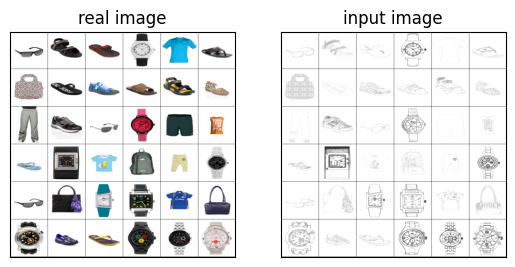

In [ ]:
for real, edge in dataloader:
  real = utils.make_grid(real, normalize=True, nrow=6)
  edge = utils.make_grid(edge, normalize=True, nrow=6)

  real = real.permute(1,2,0).numpy()
  edge = edge.permute(1,2,0).numpy()

  #plt.figure(figsize=(10,10))

  plt.subplot(1,2,1)
  plt.imshow(real)
  plt.title("real image")
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1,2,2)
  plt.imshow(edge)
  plt.title("input image")
  plt.xticks([])
  plt.yticks([])

  plt.show()
  break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_channels),
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        # Initial convolutional layer
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Downsampling
        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256, 256) for _ in range(num_residual_blocks)]
        )

        # Upsampling
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Output layer
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.residual_blocks(x)
        x = self.upsampling(x)
        x = self.output_layer(x)
        return torch.tanh(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=6):  # Changed in_channels to 6
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),  # Changed in_channels to 6
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, real, edge):
        img_input = torch.cat((real, edge), 1)
        return self.model(img_input)


In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from torchsummary import summary

In [ ]:
epoch = 0
n_epochs = 50
dataset_name = "fashion"
batch_size = 1
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 8
img_height = 256
img_width = 256
channels = 3
sample_interval = 200
checkpoint_interval = 1

In [ ]:
os.makedirs('/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/images', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models', exist_ok=True)

In [ ]:
cuda = True if torch.cuda.is_available() else False
cuda

True

In [ ]:
import torch

# Cek apakah CUDA (GPU) tersedia
if torch.cuda.is_available():
    # Dapatkan nama GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f'GPU tersedia: {gpu_name}')
else:
    print('Tidak ada GPU yang tersedia.')


GPU tersedia: Tesla T4


In [ ]:
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

In [ ]:
lambda_pixel = 100

In [ ]:
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)
patch

(1, 16, 16)

In [ ]:
# Menentukan jumlah saluran masukan dan keluaran
in_channels = 3  # Jumlah saluran masukan
out_channels = 3  # Jumlah saluran keluaran

In [ ]:
generator = GeneratorResNet(in_channels, out_channels)
discriminator = Discriminator()

In [ ]:
if cuda:
  generator = generator.cuda()
  discriminator = discriminator.cuda()
  criterion_GAN.cuda()
  criterion_pixelwise.cuda()

In [ ]:
if next(generator.parameters()).is_cuda:
    print("Model berada di GPU.")
else:
    print("Model berada di CPU.")

Model berada di GPU.


In [ ]:
if next(discriminator.parameters()).is_cuda:
    print("Model berada di GPU.")
else:
    print("Model berada di CPU.")

Model berada di GPU.


In [ ]:
summary(generator, input_size=(in_channels, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-5        [-1, 128, 128, 128]               0
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-8          [-1, 256, 64, 64]               0
              ReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-11          [-1, 256, 64, 64]               0
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-14          [-1, 256,

In [ ]:
summary(discriminator, input_size=[(3, 256, 256), (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-10          [-1, 512, 16, 16]               0
        LeakyReLU-11          [-1, 512, 16, 16]               0
        ZeroPad2d-12          [-1, 512, 17, 17]               0
           Conv2d-13            [-1, 1, 16, 16]           8,192
Total params: 2,767,808
Trainable param

In [ ]:
if epoch != 0:
  generator.load_state_dict(torch.load(f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/generator_{epoch}"))
  discriminator.load_state_dict(torch.load(f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/discriminator_{epoch}"))
else:
  generator.apply(weights_init_normal)
  discriminator.apply(weights_init_normal)

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_dataloader = DataLoader(
    ProductDataset(root_dir=TRAIN_PATH, transform=transform),
    batch_size=1,
    shuffle=True,
    num_workers=n_cpu,
)

val_dataloader = DataLoader(
    ProductDataset(root_dir=VAL_PATH, transform=transform),
    batch_size=1,
    shuffle=True,
    num_workers=1,
)
test_dataloader = DataLoader(
    ProductDataset(root_dir=TEST_PATH, transform=transform),
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
Tensor

torch.cuda.FloatTensor

In [ ]:
def sample_images(batches_done):
    imgs = next(iter(val_dataloader))
    img_edge = Variable(imgs[1].type(Tensor))
    img_real = Variable(imgs[0].type(Tensor))
    img_generator = generator(img_edge)

    # Save edge image
    save_image(img_edge.data, f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/images/edge_{batches_done}.jpg", nrow=5, normalize=True)

    # Save real image
    save_image(img_real.data, f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/images/real_{batches_done}.jpg", nrow=5, normalize=True)

    # Save generated image
    save_image(img_generator.data, f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/images/generated_{batches_done}.jpg", nrow=5, normalize=True)


In [ ]:
d_loss_list = []
g_loss_list = []
pixel_loss_list = []
gan_loss_list = []

In [ ]:
import csv

In [ ]:
prev_time = time.time()
filecsv = '/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/loss.csv'

for epoch in range(epoch, n_epochs):
    d_loss = []
    g_loss = []
    pixel_loss = []
    gan_loss = []

    for i, batch in enumerate(test_dataloader):
        img_edge = Variable(batch[1].type(Tensor)).cuda()
        img_real = Variable(batch[0].type(Tensor)).cuda()

        valid = torch.tensor(np.ones((img_edge.size(0), *patch)), dtype=torch.float32, device='cuda').requires_grad_(False)
        fake = torch.tensor(np.zeros((img_edge.size(0), *patch)), dtype=torch.float32, device='cuda').requires_grad_(False)

        optimizer_G.zero_grad()

        img_generator = generator(img_edge)

        pred_fake = discriminator(img_generator, img_edge)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(img_generator, img_real)

        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        optimizer_D.zero_grad()

        pred_real = discriminator(img_real, img_edge)
        loss_real = criterion_GAN(pred_real, valid)

        pred_fake = discriminator(img_generator.detach(), img_edge)
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        batches_done = epoch * len(test_dataloader) + i
        batches_left = n_epochs * len(test_dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        sys.stdout.write(
            f"\r[Epoch {epoch, n_epochs}] [Batch {i, len(test_dataloader)}] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}, pixel: {loss_pixel.item()}, adv: {loss_GAN.item()}] ETA: {time_left}"
        )
        d_loss.append(loss_D.item())
        g_loss.append(loss_G.item())
        pixel_loss.append(loss_pixel.item())
        gan_loss.append(loss_GAN.item())

        if batches_done % sample_interval == 0:
            sample_images(batches_done)
            d_loss_list.append(np.mean(np.array(d_loss)))
            g_loss_list.append(np.mean(np.array(g_loss)))
            pixel_loss_list.append(np.mean(np.array(pixel_loss)))
            gan_loss_list.append(np.mean(np.array(gan_loss)))

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        torch.save(generator.state_dict(), f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/generator_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/discriminator_{epoch}.pth")
        torch.save({
            'epoch':epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optimizer_state_dict': optimizer_G.state_dict(),
            'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
        }, f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/checkpoint_epoch_{epoch + 1}.pth")
        if epoch != 0:
          checkpoint_file = f'/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/checkpoint_epoch_{epoch}.pth'
          generator_file = f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/generator_{epoch}.pth"
          discriminator_file = f"/content/drive/MyDrive/Final Project4/Pinka/Arsitektur-1/saved_models/discriminator_{epoch}.pth"
          os.remove(checkpoint_file)
          os.remove(generator_file)
          os.remove(discriminator_file)

        all_losses = {'epoch':epoch+1,
                      'discriminator_loss':np.mean(d_loss),
                      'generator_loss':np.mean(g_loss),
                      'pixel_loss':np.mean(pixel_loss),
                      'gan_loss':np.mean(gan_loss)}

        with open(filecsv, 'a', newline='') as csvfile:
          fieldnames = ['epoch', 'discriminator_loss', 'generator_loss', 'pixel_loss', 'gan_loss']
          writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
          writer.writeheader()
          writer.writerow(all_losses)

[Epoch (21, 50)] [Batch (1086, 1906)] [D loss: 0.14676783978939056] [G loss: 5.330378532409668, pixel: 0.05076419562101364, adv: 0.253959059715271] ETA: 3:52:25.267144

# PNSR DAN INCEPTION SCORE

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def calculate_PSNR_for_images(original_path, compressed_path):
    original = cv2.imread(original_path)
    compressed = cv2.imread(compressed_path, 1)
    value = PSNR(original, compressed)
    return value

def main():
    # Path ke direktori hasil gambar
    images_path = "/content/drive/MyDrive/Final Project/Pinka/training50_resnet/Arsitektur-1/images"

    # Daftar semua file di direktori
    image_files = os.listdir(images_path)

    # Memfilter file-file tertentu (misalnya, hanya file generated yang ingin dihitung PSNR)
    generated_files = [file for file in image_files if "generated" in file]

    # Inisialisasi variabel untuk menghitung rata-rata PSNR
    total_psnr = 0.0
    num_images = len(generated_files)

    # Hitung dan tampilkan PSNR untuk setiap pasangan gambar real dan gambar yang dihasilkan
    for generated_file in generated_files:
        real_file = generated_file.replace("generated", "real")
        original_path = os.path.join(images_path, real_file)
        compressed_path = os.path.join(images_path, generated_file)
        psnr_value = calculate_PSNR_for_images(original_path, compressed_path)
        total_psnr += psnr_value
        print(f"PSNR value for {real_file} vs {generated_file} is {psnr_value} dB")

        # Menampilkan gambar menggunakan cv2_imshow
        original = cv2.imread(original_path)
        compressed = cv2.imread(compressed_path, 1)
        cv2_imshow(original)
        cv2_imshow(compressed)

    # Menghitung rata-rata PSNR
    average_psnr = total_psnr / num_images
    print(f"\nAverage PSNR for all images: {average_psnr} dB")

if __name__ == "__main__":
    main()


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def calculate_PSNR_for_images(original_path, compressed_path):
    original = cv2.imread(original_path)
    compressed = cv2.imread(compressed_path, 1)
    value = PSNR(original, compressed)
    return value

def main():
    # Path ke direktori hasil gambar
    images_path = "/content/drive/MyDrive/Final Project/Pinka/testing50_unet/Arsitektur-1/images"

    # Daftar semua file di direktori
    image_files = os.listdir(images_path)

    # Memfilter file-file tertentu (misalnya, hanya file generated yang ingin dihitung PSNR)
    generated_files = [file for file in image_files if "generated" in file]

    # Inisialisasi variabel untuk menghitung rata-rata PSNR
    total_psnr = 0.0
    num_images = len(generated_files)

    # Hitung dan tampilkan PSNR untuk setiap pasangan gambar real dan gambar yang dihasilkan
    for generated_file in generated_files:
        real_file = generated_file.replace("generated", "real")
        original_path = os.path.join(images_path, real_file)
        compressed_path = os.path.join(images_path, generated_file)
        psnr_value = calculate_PSNR_for_images(original_path, compressed_path)
        total_psnr += psnr_value
        print(f"PSNR value for {real_file} vs {generated_file} is {psnr_value} dB")

        # Menampilkan gambar menggunakan cv2_imshow
        original = cv2.imread(original_path)
        compressed = cv2.imread(compressed_path, 1)
        cv2_imshow(original)
        cv2_imshow(compressed)

    # Menghitung rata-rata PSNR
    average_psnr = total_psnr / num_images
    print(f"\nAverage PSNR for all images: {average_psnr} dB")

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
from numpy import asarray, expand_dims, log, mean, exp

# Fungsi perhitungan Inception Score
def calculate_inception_score(p_yx, eps=1E-16):
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)
    avg_kl_d = mean(sum_kl_d)
    is_score = exp(avg_kl_d)
    return is_score

# Fungsi untuk menghitung distribusi probabilitas dari model (contoh sederhana)
def calculate_class_distribution(images_path):
    # Simulasi: Distribusi proporsional untuk tiga kelas
    num_images = len(os.listdir(images_path))
    class_distribution = np.random.dirichlet(np.ones(3), size=num_images)
    return class_distribution

# Fungsi untuk menghitung Inception Score dari gambar-gambar di path tertentu
def calculate_inception_score_for_images(images_path):
    # Hitung distribusi probabilitas kelas dari model
    p_yx = calculate_class_distribution(images_path)

    # Hitung Inception Score
    score = calculate_inception_score(p_yx)
    return score

# Path ke direktori hasil gambar
images_path = "/content/drive/MyDrive/Final Project/Pinka/testing50_resnet/Pinka/Arsitektur-1/images"

# Hitung dan tampilkan Inception Score untuk gambar-gambar di path tertentu
inception_score = calculate_inception_score_for_images(images_path)
print(f"Inception Score: {inception_score}")


Inception Score: 1.3002420643781165


In [ ]:
import os
import numpy as np
from numpy import asarray, expand_dims, log, mean, exp

# Fungsi perhitungan Inception Score
def calculate_inception_score(p_yx, eps=1E-16):
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)
    avg_kl_d = mean(sum_kl_d)
    is_score = exp(avg_kl_d)
    return is_score

# Fungsi untuk menghitung distribusi probabilitas dari model (contoh sederhana)
def calculate_class_distribution(images_path):
    # Simulasi: Distribusi proporsional untuk tiga kelas
    num_images = len(os.listdir(images_path))
    class_distribution = np.random.dirichlet(np.ones(3), size=num_images)
    return class_distribution

# Fungsi untuk menghitung Inception Score dari gambar-gambar di path tertentu
def calculate_inception_score_for_images(images_path):
    # Hitung distribusi probabilitas kelas dari model
    p_yx = calculate_class_distribution(images_path)

    # Hitung Inception Score
    score = calculate_inception_score(p_yx)
    return score

# Path ke direktori hasil gambar
images_path = "/content/drive/MyDrive/Final Project/Pinka/testing50_unet/Arsitektur-1/images"

# Hitung dan tampilkan Inception Score untuk gambar-gambar di path tertentu
inception_score = calculate_inception_score_for_images(images_path)
print(f"Inception Score: {inception_score}")


Inception Score: 1.3046851843063978


# VISUALISASI

In [ ]:
import pandas as pd

# Ganti path dengan path sesuai dengan lokasi file CSV Anda
file_path = '/content/drive/MyDrive/Final Project/Pinka/training50_resnet/Arsitektur-1/loss - loss.csv'

# Baca data dari file CSV
df = pd.read_csv(file_path)

# Menampilkan tabel
df


,epoch,discriminator_loss,generator_loss,pixel_loss,gan_loss,epoch_time
0,1,0.169893,16.011179,0.153310,0.680159,0.415927
1,2,0.144736,13.792767,0.130931,0.699675,0.588164
2,3,0.147106,13.017121,0.123432,0.673962,0.473595
3,4,0.146230,12.488613,0.118297,0.658915,0.476380
4,5,0.147393,12.171831,0.115265,0.645330,0.473694
5,6,0.144789,11.954903,0.113083,0.646567,0.474743
6,7,0.142305,11.753648,0.111062,0.647409,0.494608
7,8,0.139905,11.573579,0.109223,0.651288,0.477181
8,9,0.134623,11.430687,0.107646,0.666110,0.499547
9,10,0.139219,11.281195,0.106337,0.647460,0.476550


from matplotlib import pyplot as plt
df['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['discriminator_loss'].plot(kind='hist', bins=20, title='discriminator_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['generator_loss'].plot(kind='hist', bins=20, title='generator_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['pixel_loss'].plot(kind='hist', bins=20, title='pixel_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='epoch', y='discriminator_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='discriminator_loss', y='generator_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='generator_loss', y='pixel_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='pixel_loss', y='gan_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['discriminator_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('discriminator_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['generator_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('generator_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['pixel_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('pixel_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['gan_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('gan_loss')

from matplotlib import pyplot as plt
df['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['discriminator_loss'].plot(kind='line', figsize=(8, 4), title='discriminator_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['generator_loss'].plot(kind='line', figsize=(8, 4), title='generator_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['pixel_loss'].plot(kind='line', figsize=(8, 4), title='pixel_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd

# Ganti path dengan path sesuai dengan lokasi file CSV Anda
file_path = '/content/drive/MyDrive/Final Project/Pinka/testing50_resnet/Pinka/Arsitektur-1/loss_data.csv'

# Baca data dari file CSV
df = pd.read_csv(file_path)

# Menampilkan tabel
df

,epoch,discriminator_loss,generator_loss,pixel_loss,gan_loss
0,1,0.220306,18.154923,0.175410,0.613898
1,2,0.154776,15.918463,0.152252,0.693275
2,3,0.140684,15.034502,0.143135,0.720973
3,4,0.136969,14.383239,0.136596,0.723663
4,5,0.139772,13.906220,0.132013,0.704940
5,6,0.150230,13.536743,0.128569,0.679813
6,7,0.146441,13.178992,0.124987,0.680270
7,8,0.144366,12.910959,0.122297,0.681298
8,9,0.148872,12.765266,0.121047,0.660524
9,10,0.148911,12.472884,0.118119,0.660954


from matplotlib import pyplot as plt
df['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['discriminator_loss'].plot(kind='hist', bins=20, title='discriminator_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['generator_loss'].plot(kind='hist', bins=20, title='generator_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['pixel_loss'].plot(kind='hist', bins=20, title='pixel_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='epoch', y='discriminator_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='discriminator_loss', y='generator_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='generator_loss', y='pixel_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='pixel_loss', y='gan_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['discriminator_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('discriminator_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['generator_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('generator_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['pixel_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('pixel_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['gan_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('gan_loss')

from matplotlib import pyplot as plt
df['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['discriminator_loss'].plot(kind='line', figsize=(8, 4), title='discriminator_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['generator_loss'].plot(kind='line', figsize=(8, 4), title='generator_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['pixel_loss'].plot(kind='line', figsize=(8, 4), title='pixel_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd

# Ganti path dengan path sesuai dengan lokasi file CSV Anda
file_path = '/content/drive/MyDrive/Final Project/Pinka/testing50_unet/Arsitektur-1/loss_data.csv'

# Baca data dari file CSV
df = pd.read_csv(file_path)

# Menampilkan tabel
df

,epoch,discriminator_loss,generator_loss,pixel_loss,gan_loss
0,1,0.202034,17.265050,0.165977,0.667318
1,2,0.152919,14.740188,0.140420,0.698201
2,3,0.153550,14.111390,0.134170,0.694368
3,4,0.151933,13.746248,0.130645,0.681760
4,5,0.146305,13.530433,0.128395,0.690976
5,6,0.138882,13.103568,0.124035,0.700028
6,7,0.140241,12.878524,0.121843,0.694176
7,8,0.148618,12.476253,0.118121,0.664115
8,9,0.146384,12.168233,0.115029,0.665322
9,10,0.148218,11.801999,0.111484,0.653582


from matplotlib import pyplot as plt
df['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['discriminator_loss'].plot(kind='hist', bins=20, title='discriminator_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['generator_loss'].plot(kind='hist', bins=20, title='generator_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['pixel_loss'].plot(kind='hist', bins=20, title='pixel_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='epoch', y='discriminator_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='discriminator_loss', y='generator_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='generator_loss', y='pixel_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='pixel_loss', y='gan_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['discriminator_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('discriminator_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['generator_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('generator_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['pixel_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('pixel_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['gan_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('gan_loss')

from matplotlib import pyplot as plt
df['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['discriminator_loss'].plot(kind='line', figsize=(8, 4), title='discriminator_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['generator_loss'].plot(kind='line', figsize=(8, 4), title='generator_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['pixel_loss'].plot(kind='line', figsize=(8, 4), title='pixel_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

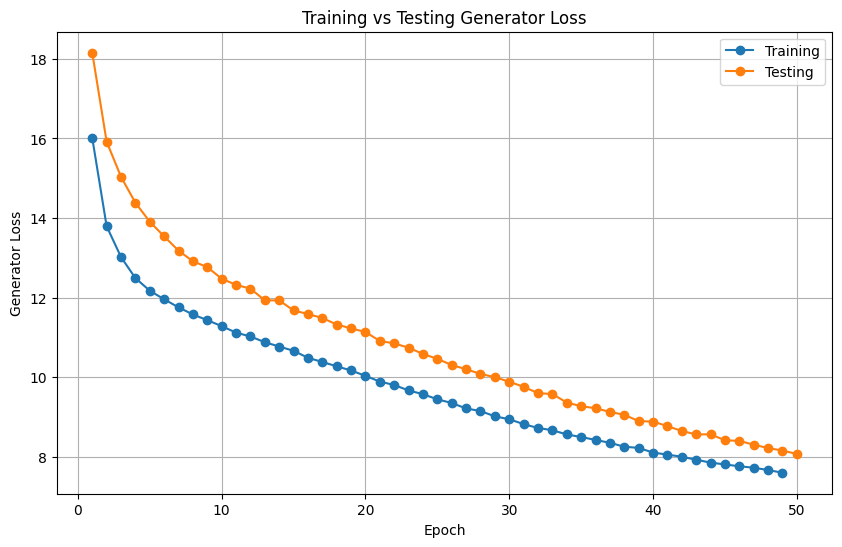

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ganti path dengan path sesuai dengan lokasi file CSV training
train_file_path = '/content/drive/MyDrive/Final Project/Pinka/training50_resnet/Arsitektur-1/loss - loss.csv'

# Ganti path dengan path sesuai dengan lokasi file CSV testing
test_file_path = '/content/drive/MyDrive/Final Project/Pinka/testing50_resnet/Pinka/Arsitektur-1/loss_data.csv'

# Baca data dari file CSV training
train_df = pd.read_csv(train_file_path)

# Baca data dari file CSV testing
test_df = pd.read_csv(test_file_path)

# Buat plot untuk membandingkan discriminator_loss
plt.figure(figsize=(10, 6))
plt.plot(train_df['epoch'], train_df['generator_loss'], label='Training', marker='o')
plt.plot(test_df['epoch'], test_df['generator_loss'], label='Testing', marker='o')

# Atur label dan judul plot
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Training vs Testing Generator Loss')
plt.legend()
plt.grid(True)
plt.show()


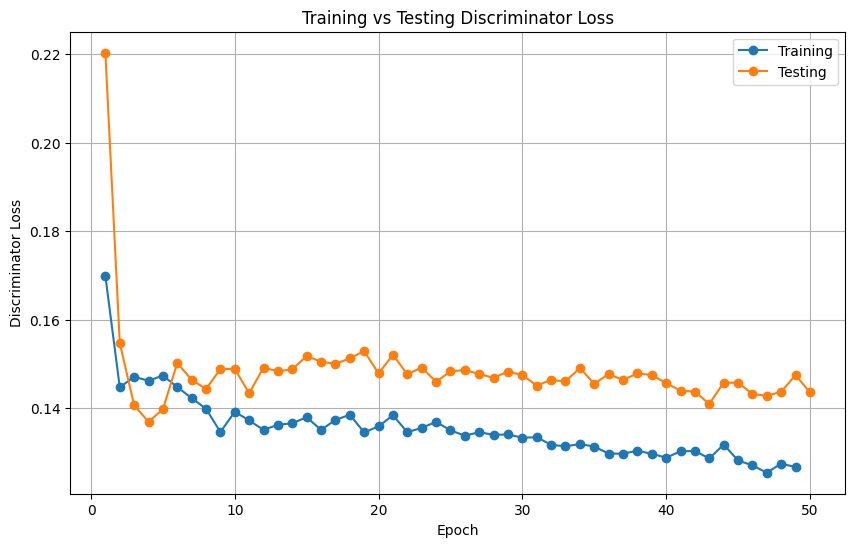

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ganti path dengan path sesuai dengan lokasi file CSV training
train_file_path = '/content/drive/MyDrive/Final Project/Pinka/training50_resnet/Arsitektur-1/loss - loss.csv'

# Ganti path dengan path sesuai dengan lokasi file CSV testing
test_file_path = '/content/drive/MyDrive/Final Project/Pinka/testing50_resnet/Pinka/Arsitektur-1/loss_data.csv'

# Baca data dari file CSV training
train_df = pd.read_csv(train_file_path)

# Baca data dari file CSV testing
test_df = pd.read_csv(test_file_path)

# Buat plot untuk membandingkan discriminator_loss
plt.figure(figsize=(10, 6))
plt.plot(train_df['epoch'], train_df['discriminator_loss'], label='Training', marker='o')
plt.plot(test_df['epoch'], test_df['discriminator_loss'], label='Testing', marker='o')

# Atur label dan judul plot
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.title('Training vs Testing Discriminator Loss')
plt.legend()
plt.grid(True)
plt.show()
